# Lab 7 Report

Prepared by Zech Wolf

## 1. Data preparation

The dataset used in this report is the Sentiment140 dataset, which consists of 1.6 million tweets. The target variable is the tweet's sentiment, on a scale of 0 (negative) to 4(positive), with 2 being neutral. The provided training set only includes examples of class 0 and 4, which were automatically labelled based on emoticons (https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf). A small, manually labelled testing set with about 500 examples of all labels is provided as well.

For this report, I will be using only the provided training set as the full dataset, and simplifying the labels to negative and positive, 0 and 1. I believe that the small size of the testing set is a disadvantage for evaluating the generalization performance of different models.

As distributed, there were some formatting issues with the CSV. I added the column names to the top of the CSV file, and used an auto-fix in VS Code to standardize the line separating characters, which were causing a problem with the Pandas read_csv function.

The dataset includes some metadata about each tweet, but it is not overly important for this task, so it is ignored.

Dataset source: https://www.kaggle.com/datasets/kazanova/sentiment140

### 1.1 Preprocessing

The dataset needs to be cleaned up and formatted to facilitate the learning task. Each tweet is whitespace-tokenized, stop words are removed, and the tokens are stemmed. Also, following the recommendations of the Sentiment140 paper, mentions of other users on Twitter (such as @username) are replaced with a universal identifer "USERNAME." Likewise, URLs are replaced with "URL." Since usernames and URLs are fairly unique, this should hopefully reduce the number of tokens with low frequencies in the dataset, and allow the model to generalize the significance of mentioning other users and linking to webpages. The tokens are then recombined to form a set of preprocessed tweets.

The preprocessed tweets are tokenized again and converted into sequences of integer labels. The entire vocabulary is kept. The sequences are zero-padded to match the length of the longest tweet in the dataset, so that all sequences are the same length.

In [1]:
import pandas as pd

df = pd.read_csv("datasets/training.1600000.processed.noemoticon.csv")
df.target.replace(4, 1, inplace=True)

In [2]:
#Sampling down to 200000 instances
df = pd.concat([
    df[df.target == 0].sample(100000, random_state=1234),
    df[df.target == 1].sample(100000, random_state=1234)
])[["target","text"]] #select only target and text

In [3]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import WhitespaceTokenizer

stemmer = SnowballStemmer("english")
sw = set(stopwords.words("english"))

def filter(token):
    if token[0] == "@":
        return "USERNAME"
    if token.startswith(("https://","http://")):
        return "URL"
    
    return stemmer.stem(token)

ws_tok = WhitespaceTokenizer()
def process(text):
    text = " ".join([filter(w.lower()) for w in ws_tok.tokenize(text) if w not in sw])
    return text

df["text"] = df.text.apply(process)

In [1]:
import pandas as pd

#Save or load the preprocessed text
SAVE = False
READ = True

if SAVE:
    df.to_pickle("datasets/text_preprocessed.pkl")

if READ:
    df = pd.read_pickle("datasets/text_preprocessed.pkl")

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(df.text))
seq = tokenizer.texts_to_sequences(list(df.text))
X = pad_sequences(seq) #pad to length of longest sequence
y = df.target.to_numpy()

In [3]:
import numpy as np

print(X.shape)
print(np.max(X))

(200000, 118)
79385


The final preprocessed datset is represented by padded sequences 118 tokens in length each. The vocabulary size is about 80,000 words

### 1.2 Evaluation metrics

A possible business case for a sentiment analyzer trained on this dataset is evaluating the online presence of a particular client. Companies, artists, content creators, and anyone else looking to understand how people online feel about their work, might be interested in a social media search engine that can provide a score based on negative and positive impressions observed on Twitter. This could be implemented by collecting recent tweets filtered by certain search terms related to the client, and predicting the sentiment using the trained RNN. The service could then give a score based on the proportion of positive and negative sentiments observed.

The sampled dataset is very large (200,000 instances). The dataset is also perfectly balanced, such that there are 100,000 instances of each class. In order to be an effective tool for sentiment analysis, each class should be treated as equally important. If the model is only good at identifying positive sentiments, then a client will see that their image online is much better than it actually is, and the reverse is true if the model is only good at identifying negative sentiments. So because of the balance of the dataset, and the equal importance of the classes, accuracy is a good metric for evaluating model performance.

### 1.3 Train-test split

Because of the size of the dataset, an 80/20 split should provide plenty of examples to train on, and evaluate performance. One factor to think about though is the class distribution of the testing set. The distribution should approximate what would be expected in a practical application of the business case, so that the testing set accuracy reflects the generalized performance of the model. However, every client is going to have a different online presence, meaning a different distribution of positive and negative sentiments. In this case then, it is reasonable to have a balanced test set for evaluating the generalization performance.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=1234)

## 2. Modeling

Two RNN architectures, GRU and LSTM, are implemented with different parameters to create four different models. The models are compared to discover which architecture and parameter set performs the best. The dropout rate in the recurrent unit is changed to observe the effect on performance.

A note on the large batch size used: early testing with a smaller batch size of 64 resulted in the validation loss rapidly increasing after just a few epochs. I experimented with larger batch sizes and found that larger batch sizes helped prevent this, so I settled to use a batch size of 8192 and allow the model to train for more epochs.

### 2.1 Importing GloVe embeddings

All models make use of pretrained GloVe word embeddings, specifically the 200-dimensional weights trained on a Twitter dataset.

https://nlp.stanford.edu/projects/glove/

In [5]:
#Code adapted from example notebook and keras docs
import numpy as np
from keras.layers import Embedding

embeddings_index = {}

f = open("datasets/glove.twitter.27B.200d.txt", encoding="utf8")
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
word_index = tokenizer.word_index

EMBED_SIZE = 200
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=X.shape[1],
                            trainable=False)

#End code from example notebook and keras docs

Found 1193514 word vectors.
Embedding Shape: (79386, 200) 
 Total words found: 47196 
 Percentage: 59.45128864031442


About 60% of the vocabulary is accounted for in GloVe. The rest are initialized to zero vectors.

#### Visualization and comparisons code

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_performance(hist):
    plt.figure(figsize=(14,6))

    #accuracy plot
    plt.subplot(1,2,1)
    epochs = range(len(hist.epoch))
    accuracy = hist.history["accuracy"]
    val_accuracy = hist.history["val_accuracy"]

    sns.lineplot(x=epochs, y=accuracy, label="Training accuracy")
    sns.lineplot(x=epochs, y=val_accuracy, label="Validation accuracy")

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy vs. Epoch")

    #Loss plot
    plt.subplot(1,2,2)
    loss = hist.history["loss"]
    val_loss = hist.history["val_loss"]

    sns.lineplot(x=epochs, y=loss, label="Training loss")
    sns.lineplot(x=epochs, y=val_loss, label="Validation loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss vs. Epoch")
    plt.show()

In [7]:
#McNemars test for stat comparison
def get_contingency(yhat1, yhat2, y):
    """Generate the contingency matrix """
    contingency = np.zeros((2,2))
    for i in range(len(y)): #slow but it works
        if yhat1[i] == y[i] and yhat2[i] == y[i]: #A
            contingency[0,0] += 1
        elif yhat1[i] == y[i] and yhat2[i] != y[i]: #B
            contingency[0,1] += 1
        elif yhat1[i] != y[i] and yhat2[i] == y[i]: #C
            contingency[1,0] += 1
        elif yhat1[i] != y[i] and yhat2[i] != y[i]: #D
            contingency[1,1] += 1

    return contingency

def mcnemar(yhat1, yhat2, y):
    """Get the chi2 value for McNemar's test"""
    contingency = get_contingency(yhat1, yhat2, y)
    B = contingency[0,1]
    C = contingency[1,0]

    return ((np.abs(B-C) - 1)**2) / (B + C)

In [8]:
from sklearn.metrics import accuracy_score

def model_report(model, y_test):
    y_score = model.predict(X_test)
    y_pred = np.round(y_score)
    print(f"Test set accuracy: {accuracy_score(y_test, y_pred)}")
    return y_pred

### 2.2 GRU Architecture

The first RNN architecture tested here uses GRU, with the following architecture:
* GloVe embedding layer
* GRU (64 units)
* Sigmoid activated output layer

The dropout rate in the GRU layer is modified to create two different models.

#### 2.2.1 RNN 1

The first implementation uses a dropout rate of $0.1$

In [178]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.regularizers import L2

rnn1 = Sequential([
    embedding_layer,
    GRU(64, dropout=0.1),
    Dense(1, activation="sigmoid")
])

rnn1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [179]:
h1 = rnn1.fit(X_train, y_train, batch_size=8192, epochs=100, validation_data=(X_test, y_test), verbose=0)

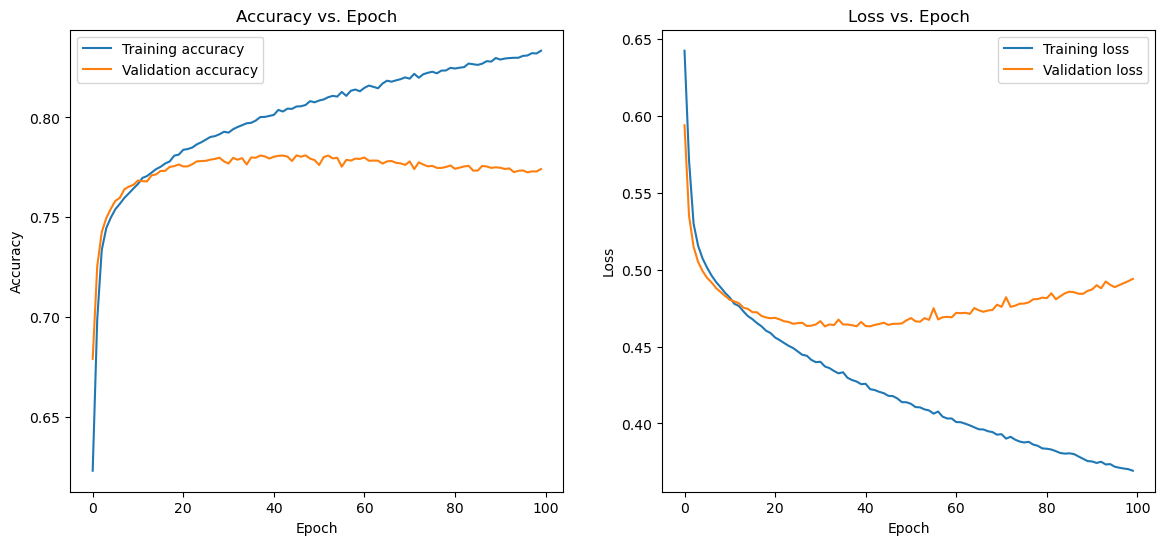

Test set accuracy: 0.774175


In [180]:
plot_performance(h1)
y_pred1 = model_report(rnn1, y_test)
np.save("datasets/y_pred1.npy", y_pred1)

With a low dropout rate, the network struggles to converge after 100 epochs. The training loss is still dropping, but after about 50 epochs, the validation loss starts increasing significantly. Near the end of training, the validation accuracy also starts to decrease. The network seems to be overfitting to the training data. 

#### 2.2.3 RNN 2

The second implementation of the GRU architecture uses a dropout rate of $0.6$

In [181]:
rnn2 = Sequential([
    embedding_layer,
    GRU(64, dropout=0.6),
    Dense(1, activation="sigmoid")
])

rnn2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [182]:
h2 = rnn2.fit(X_train, y_train, batch_size=8192, epochs=100, validation_data=(X_test, y_test), verbose=0)

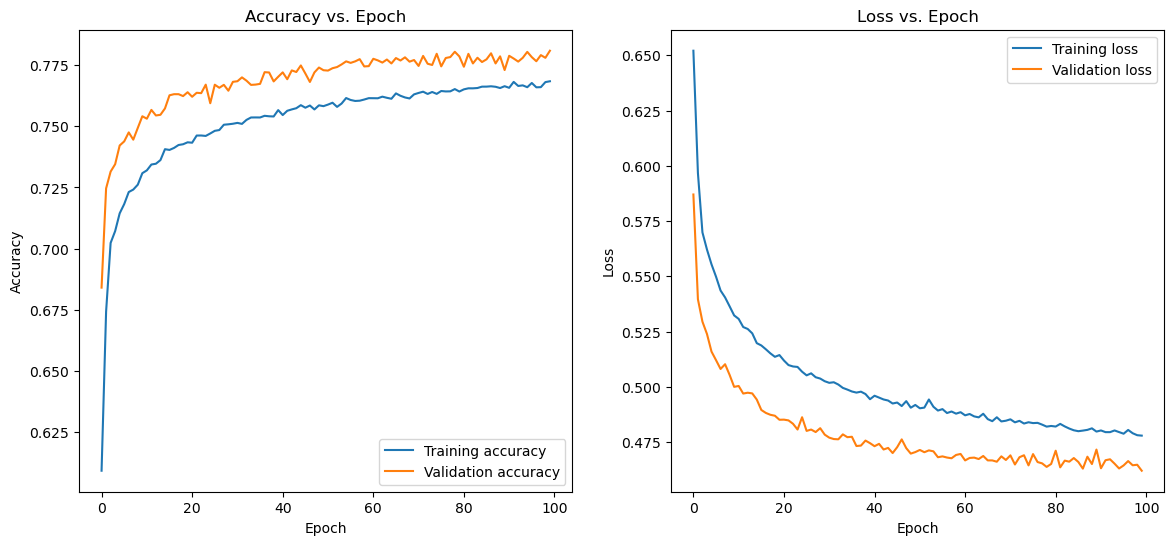

Test set accuracy: 0.7809


In [183]:
plot_performance(h2)
y_pred2 = model_report(rnn2, y_test)
np.save("datasets/y_pred2.npy", y_pred2)

With a higher dropout rate, the network is able to converge after 100 epochs. There doesn't appear to be any overfitting, and the test set accuracy is better than RNN 1. It seems that more regularization from the higher dropout rate benefits the stability of the network and helps it to converge faster.

### 2.3 LSTM Architecture

This architecture has the same structure as the GRU architecture, but uses an LSTM layer instead of GRU.

#### 2.3.1 RNN 3

The first implementation of the LSTM architecture uses a dropout rate of $0.1$

In [138]:
from keras.layers import LSTM

rnn3 = Sequential([
    embedding_layer,
    LSTM(64, dropout=0.1),
    Dense(1, activation="sigmoid")
])

rnn3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [139]:
h3 = rnn3.fit(X_train, y_train, batch_size=8192, epochs=100, validation_data=(X_test, y_test), verbose=0)

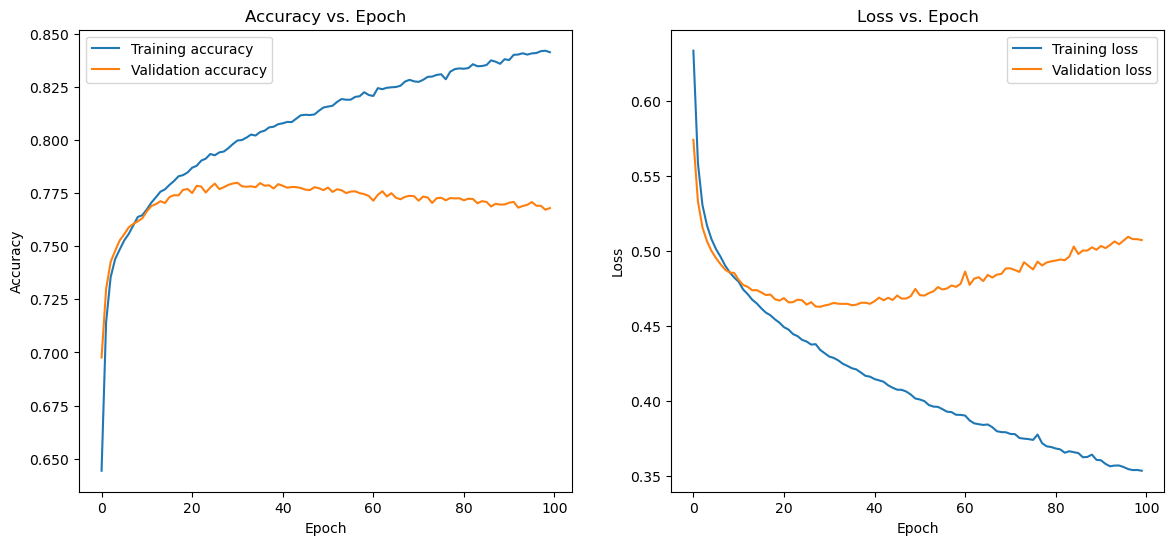

Test set accuracy: 0.7679


In [140]:
plot_performance(h3)
y_pred3 = model_report(rnn3, y_test)
np.save("datasets/y_pred3.npy", y_pred3)

The LSTM network also struggles to converge with a lower dropout rate. With less regularization, the network is more susceptible to overfitting and does not converge as nicely.

#### 2.3.2 RNN 4

The second implementation of the LSTM architecture uses a dropout rate of $0.6$

In [141]:
rnn4 = Sequential([
    embedding_layer,
    LSTM(64, dropout=0.6),
    Dense(1, activation="sigmoid")
])

rnn4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [142]:
h4 = rnn4.fit(X_train, y_train, batch_size=8192, epochs=100, validation_data=(X_test, y_test), verbose=0)

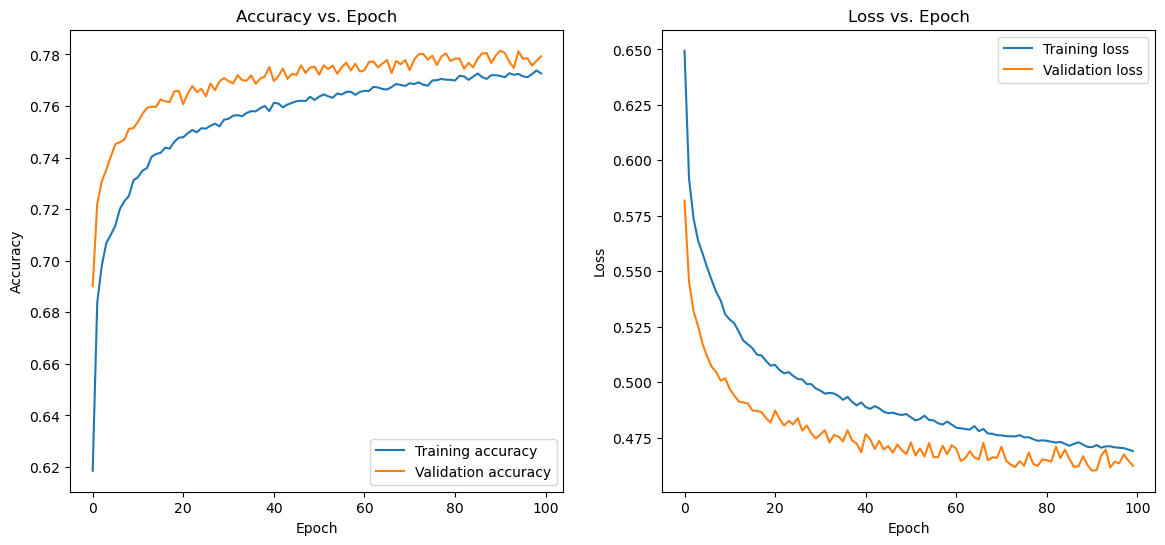

Test set accuracy: 0.7793


In [143]:
plot_performance(h4)
y_pred4 = model_report(rnn4, y_test)
np.save("datasets/y_pred4.npy", y_pred4)

The higher dropout rate allows the LSTM to converge faster, and the accuracy is improved by about 1%. Both the GRU and LSTM architectures benefit from higher dropout rates, and have trouble with overfitting when the dropout rate is too low.

### 2.4 Model comparisons

The models are all close in terms of accuracy. McNemar's test is used to determine if there is a statistically significant difference between any models, and which set of parameters results in the best performance. For the test, a critical value of $3.841$ is used for a 95% CI

In [216]:
def compare(yhat1, yhat2, name1, name2):
    mcn = mcnemar(yhat1, yhat2, y_test)
    acc1 = accuracy_score(y_test, yhat1)
    acc2 = accuracy_score(y_test, yhat2)

    print(f"RNN {name1} vs. RNN {name2}: {mcn}")
    print(f"RNN {name1} accuracy: {acc1}")
    print(f"RNN {name2} accuracy: {acc2}")

#### 2.4.1 GRU models - RNN 1 vs. RNN 2

In [217]:
compare(y_pred1, y_pred2, 1, 2)

RNN 1 vs. RNN 2: 14.501110438118312
RNN 1 accuracy: 0.774175
RNN 2 accuracy: 0.7809


The result of the test is greater than the critical value, so there is a statistically significant difference between RNN 1 and 2. Based on the accuracy, we can determine that RNN 2 with a dropout of $0.6$ is the better implementation of the GRU architecture.

#### 2.4.2 LSTM models - RNN 3 vs. RNN 4

In [218]:
compare(y_pred3, y_pred4, 3, 4)

RNN 3 vs. RNN 4: 41.62143144350623
RNN 3 accuracy: 0.7679
RNN 4 accuracy: 0.7793


According to McNemar's test, a higher dropout rate is also beneficial to the LSTM models, as RNN 4 outperforms RNN 3 to a statistically significant degree.

#### 2.4.3 GRU vs. LSTM

In [219]:
compare(y_pred1, y_pred3, 1, 3)

RNN 1 vs. RNN 3: 10.974539069359087
RNN 1 accuracy: 0.774175
RNN 3 accuracy: 0.7679


The test shows that RNN 1 is better than RNN 3, based on accuracy. These models used a dropout rate of $0.1$. It seems that LSTM is more sensitive to the effect of regularization, while GRU can perform better with less dropout.

In [220]:
compare(y_pred2, y_pred4, 2, 4)

RNN 2 vs. RNN 4: 1.6186786296900488
RNN 2 accuracy: 0.7809
RNN 4 accuracy: 0.7793


The result does not exceed the critical value, so there is not a statistically significant difference between the best implementations of GRU and LSTM. For this classification task, it seems that the dropout rate is more important than the type of recurrent layer used. Even so, if I were to perform more in depth hyper parameter tuning, I would use GRU for testing because of its superior performance with a lower dropout rate, and its smaller number of trainable parameters.

#### 2.4.4 Overall model performance

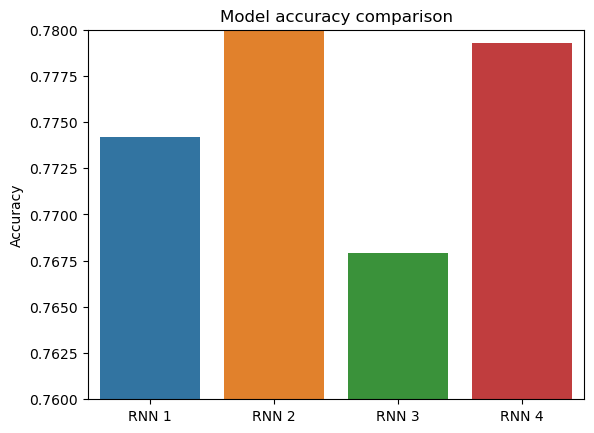

In [221]:
preds = [y_pred1, y_pred2, y_pred3, y_pred4]
accs = [accuracy_score(y_test, yhat) for yhat in preds]

sns.barplot(x=[f"RNN {i}" for i in range(1,5)], y=accs)
plt.ylabel("Accuracy")
plt.ylim((0.76,0.78))
plt.title("Model accuracy comparison")
plt.show()

Both network architectures perform well on the dataset, achieving around 78% accuracy with the best hyperparameters. The increase in performance with a higher dropout rate is obvious in both architectures, although GRU performs better than LSTM with a lower dropout rate. These results show that regularization is important for improving the stability of networks and preventing overfitting, which results in better performance in recurrent architectures for this classification task.